# Distribution_based computation of load cases 


Including the revision data and max load case is not implemented here!

Load the general room type dependent demands and the specific building demands

In [46]:
import matplotlib.pyplot as plt

from load_case_clustering import load_yaml, compute_required_volume_flows, cluster_time_slots_from_distribution, evaluate_cluster_silhouette_scores, compute_distance_matrix, compute_cluster_barycenter_pmfs, summarize_barycenter_pmfs, build_zone_pmfs, compute_cluster_time_shares

standard_data = load_yaml("../src/load_case_clustering/data/general.yml")
gpz_data = load_yaml("input_files/GPZ.yml")
rooms_to_merge = gpz_data["rooms_to_merge"]
zero_inflated_rooms = gpz_data["zero_inflated_rooms"]

compute volume flows

In [47]:
df = compute_required_volume_flows(standard_data, gpz_data, overview_flag=True, include_revision=False)

merge the zone's binomial distributions. Then compute the distance matrix which is a measure of the distance between the binomial distributions -- using the Wasserstein 1 metric.

In [48]:
zone_pmfs_by_time = build_zone_pmfs(df, rooms_to_merge, zero_inflated_rooms=zero_inflated_rooms)
dist_matrix = compute_distance_matrix(zone_pmfs_by_time)

evaluate the optimal number of clusters

Text(0, 0.5, 'SILHOUETTE SCORE')

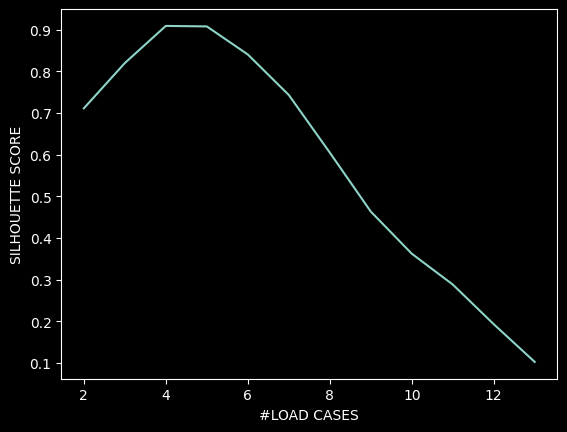

In [49]:
scores = evaluate_cluster_silhouette_scores(dist_matrix, 2, 13)

plt.plot(scores.keys(), scores.values())
plt.xlabel("#LOAD CASES")
plt.ylabel("SILHOUETTE SCORE")

In [50]:
cluster_labels, zone_pmfs_by_time = cluster_time_slots_from_distribution(df, rooms_to_merge,n_clusters=5,zero_inflated_rooms=zero_inflated_rooms)

In [51]:
cluster_barycenters = compute_cluster_barycenter_pmfs(cluster_labels,zone_pmfs_by_time,1)

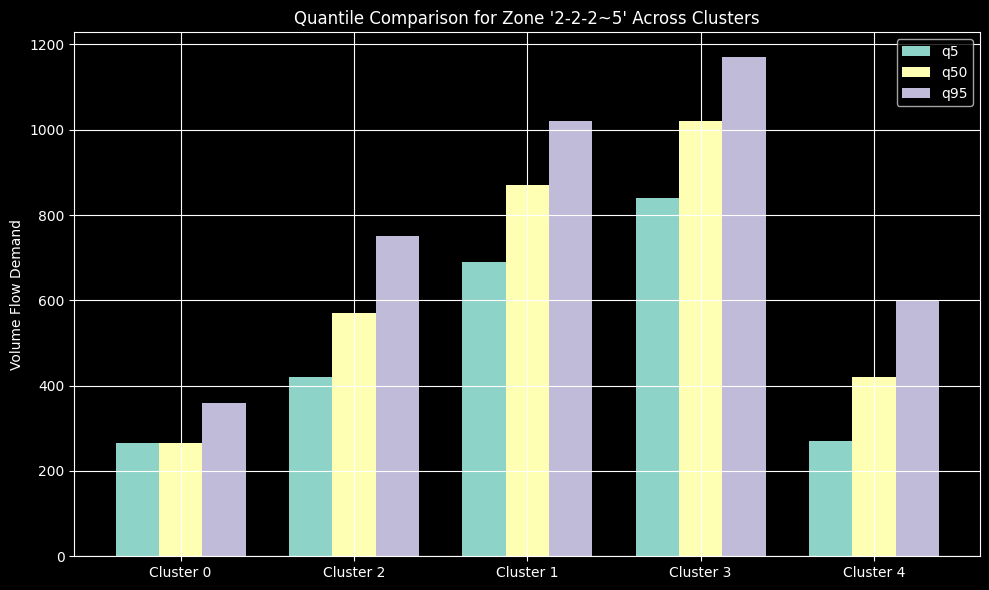

In [52]:
from load_case_clustering.wasserstein import plot_zone_quantile_comparison
plot_zone_quantile_comparison(cluster_barycenters, "2-2-2~5", quantiles=[0.05, 0.5, 0.95])

In [53]:
time_shares = compute_cluster_time_shares(cluster_labels)

In [54]:
output_values = summarize_barycenter_pmfs(cluster_barycenters, quantile=0.5)

In [55]:
from load_case_clustering import save_scenario_data_to_yaml

save_scenario_data_to_yaml({"load_cases": output_values,"time_share": time_shares}, "output_files/GPZ_distribution_based_load_cases.yml", "q50")